# Comparing Networks

In this notebook, we want to compare different network to each other.
This one focuses on...

- Generator Machine Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GEMU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [74]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "fashion_mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

2097

In [75]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [76]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [77]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [78]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Generator Machine Unlearning

In [79]:
from unlearning import unlearn_n_models, GeneratorMachineUnlearning
from training import save_model

In [80]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = GeneratorMachineUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn(logs=True)
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

Baseline Performance
Time: 0.09852790832519531
Epoch: 1, Loss: 475.502197265625
Epoch: 2, Loss: 4.990808963775635
Epoch: 3, Loss: 0.23278547823429108
Epoch: 4, Loss: -1.110818862915039
Epoch: 5, Loss: -1.2489006519317627
Epoch: 6, Loss: 2.6476199626922607
Ending NoiseGenerator Maximazation Phase
Time: 10.114448070526123
______
Starting Impairing Phase
Time: 10.210026025772095
Train loss 1: 12.654866435668218
Ending Impairing Phase
Time: 34.64913892745972
Train loss 1: 9.689957635561823
Ending Repairing Phase
Time: 44.63449311256409
______


In [81]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorMachineUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}GEMU{os.sep}test_ensemble")

Unlearning 30 models trained on fashion_mnist
Unlearned model  1/30...
Unlearned model  2/30...
Unlearned model  3/30...
Unlearned model  4/30...
Unlearned model  5/30...
Unlearned model  6/30...
Unlearned model  7/30...
Unlearned model  8/30...
Unlearned model  9/30...
Unlearned model 10/30...
Unlearned model 11/30...
Unlearned model 12/30...
Unlearned model 13/30...
Unlearned model 14/30...
Unlearned model 15/30...
Unlearned model 16/30...
Unlearned model 17/30...
Unlearned model 18/30...
Unlearned model 19/30...
Unlearned model 20/30...
Unlearned model 21/30...
Unlearned model 22/30...
Unlearned model 23/30...
Unlearned model 24/30...
Unlearned model 25/30...
Unlearned model 26/30...
Unlearned model 27/30...
Unlearned model 28/30...
Unlearned model 29/30...
Unlearned model 30/30...


___
### Exact Model

In [82]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [83]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [84]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [85]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

28.003110107282797

In [86]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

459.48027652104696

In [87]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

27.96686388415595

#### Trained to ...

In [88]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

459.49651323954265

In [89]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

29.06532600025336

#### GEMU to ...

In [90]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

460.4776472409566

#### Exact to ...

In [91]:
# see above

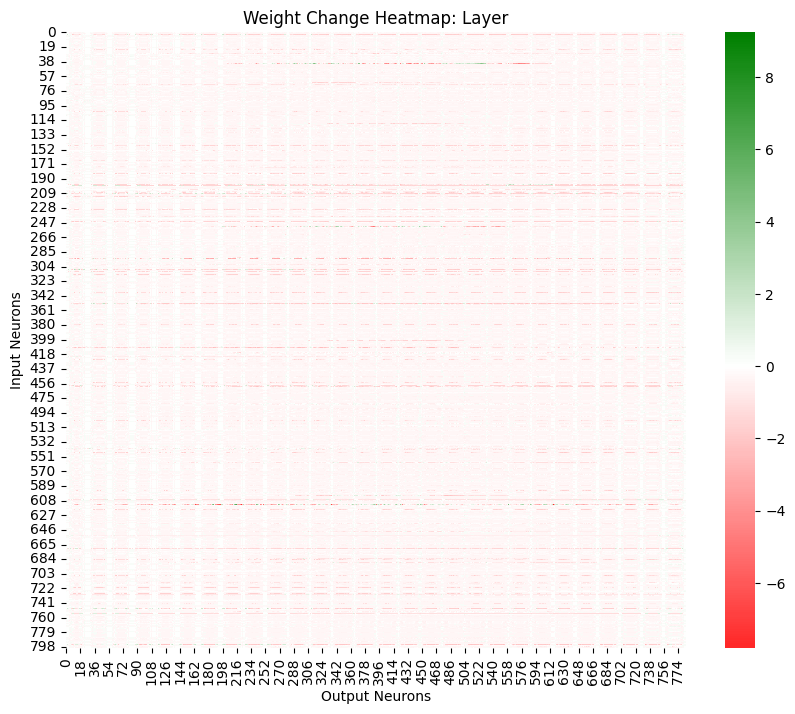

In [92]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [93]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'fc1.weight': 229736.24375,
 'fc1.bias': 372.15953369140624,
 'fc3.weight': 2634.541365559896,
 'fc3.bias': 25.057739384969075}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [94]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [95]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.8937719002573812

#### Trained to...

In [96]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.200342505930419

#### Exact to...

In [97]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.7138477198151618

#### MU to...

In [98]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

8.206160306658582

In [99]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.0703614807079798

In [100]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.8525233071453213

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [101]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'fashion_mnist'...


Average accuracy for D_gesamt: 0.5287 - Standard Deviation for D_gesamt: 0.0985


Average accuracy for D_remain: 0.5346 - Standard Deviation for D_remain: 0.1002


Average accuracy for 0: 0.2619 - Standard Deviation for 0: 0.3306


Average accuracy for 1: 0.7740 - Standard Deviation for 1: 0.3445


Average accuracy for 2: 0.4753 - Standard Deviation for 2: 0.4726


Average accuracy for 3: 0.4119 - Standard Deviation for 3: 0.3268


Average accuracy for 4: 0.2326 - Standard Deviation for 4: 0.4081


Average accuracy for 6: 0.2169 - Standard Deviation for 6: 0.3585


Average accuracy for 7: 0.8630 - Standard Deviation for 7: 0.0709


Average accuracy for 8: 0.4637 - Standard Deviation for 8: 0.4398


Average accuracy for 9: 0.9204 - Standard Deviation for 9: 0.0569


Average accuracy for 5_all: 0.6676 - Standard Deviation for 5_all: 0.0944


Average accuracy for 5_remain: 0.8296 - Standard Deviation for 5_remain: 0.0595


Average accuracy for 5_erased: 0.3660 - Standard Deviation for 5_erased: 0.1803
plotting...


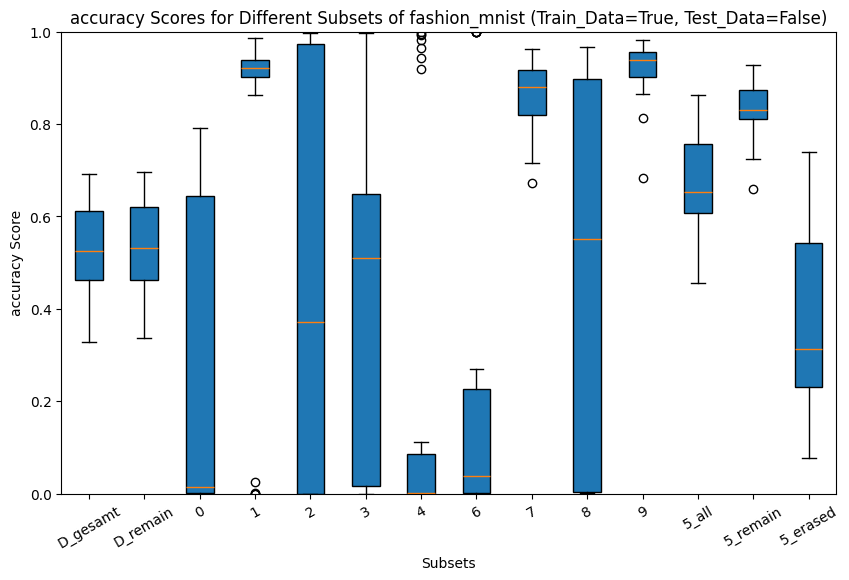

In [102]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


Average accuracy for D_gesamt: 0.5235 - Standard Deviation for D_gesamt: 0.0969


Average accuracy for D_remain: 0.5291 - Standard Deviation for D_remain: 0.0988


Average accuracy for 0: 0.2538 - Standard Deviation for 0: 0.3211


Average accuracy for 1: 0.7660 - Standard Deviation for 1: 0.3411


Average accuracy for 2: 0.4742 - Standard Deviation for 2: 0.4710


Average accuracy for 3: 0.3985 - Standard Deviation for 3: 0.3212


Average accuracy for 4: 0.2317 - Standard Deviation for 4: 0.4080


Average accuracy for 6: 0.2167 - Standard Deviation for 6: 0.3583


Average accuracy for 7: 0.8653 - Standard Deviation for 7: 0.0720


Average accuracy for 8: 0.4627 - Standard Deviation for 8: 0.4386


Average accuracy for 9: 0.9172 - Standard Deviation for 9: 0.0575


Average accuracy for 5_all: 0.6490 - Standard Deviation for 5_all: 0.0929


Average accuracy for 5_remain: 0.8104 - Standard Deviation for 5_remain: 0.0556


Average accuracy for 5_erased: 0.3777 - Standard Deviation for 5_erased: 0.1746
plotting...


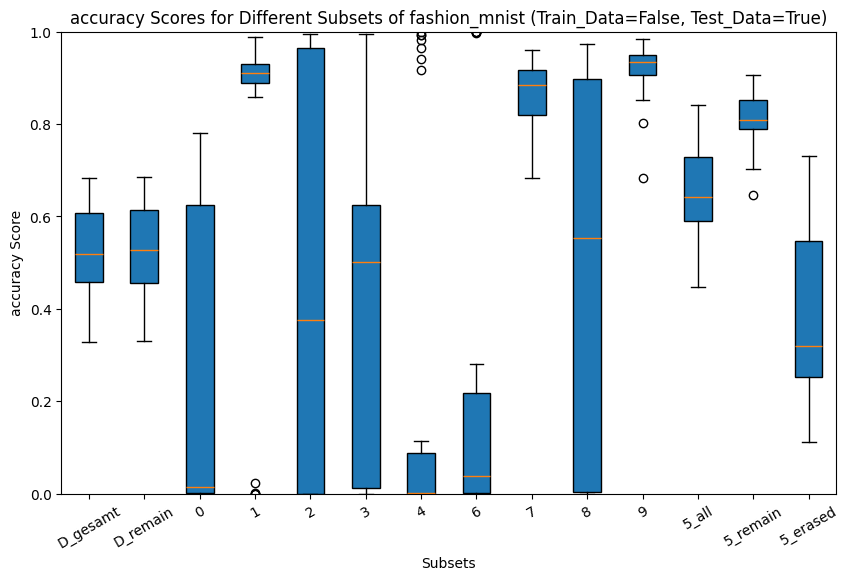

In [103]:
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [104]:
losses = {}

In [105]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'fashion_mnist'...


KeyboardInterrupt: 

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average loss for D_gesamt: 0.2845 - Standard Deviation for D_gesamt: 0.0182


Average loss for D_remain: 0.2845 - Standard Deviation for D_remain: 0.0185


Average loss for 0: 0.2835 - Standard Deviation for 0: 0.0333


Average loss for 1: 0.2821 - Standard Deviation for 1: 0.0326


Average loss for 2: 0.2840 - Standard Deviation for 2: 0.0236


Average loss for 3: 0.2865 - Standard Deviation for 3: 0.0179


Average loss for 4: 0.2847 - Standard Deviation for 4: 0.0211


Average loss for 5: 0.2870 - Standard Deviation for 5: 0.0109


Average loss for 6: 0.2865 - Standard Deviation for 6: 0.0102


Average loss for 8: 0.2883 - Standard Deviation for 8: 0.0038


Average loss for 9: 0.2900 - Standard Deviation for 9: 0.0015


Average loss for 7_all: 0.2820 - Standard Deviation for 7_all: 0.0230


Average loss for 7_remain: 0.2820 - Standard Deviation for 7_remain: 0.0277


Average loss for 7_erased: 0.2988 - Standard Deviation for 7_erased: 0.0064
plotting...


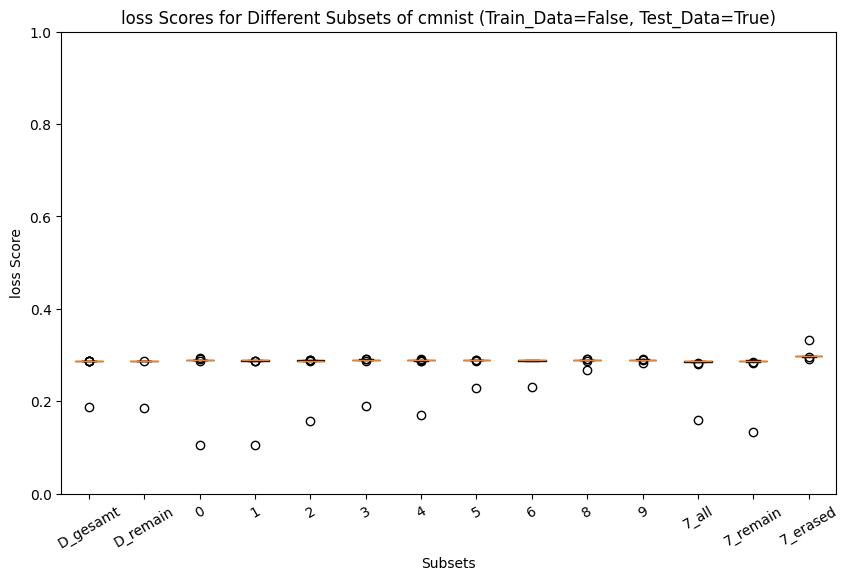

In [ ]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=False, test_split=True, logs=True)